# Global Sensitivity Analysis

This notebook is used to perform Global Sensitivity Analysis (GSA). GSA is a method used to determine how different input variables affect the output of a model. We will use two different techniques for GSA, Sobol and Feature Scoring. Sobol decomposes the variance of the output into fractions that can be attributed to inputs or combinations of inputs. Feature scoring methods assign a score to each input variable based on its importance or contribution to the output.

We chose to do both analyses to increase our confidence in the reliability of the results. If both methods give similar results, this increases our confidence in the results.

In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
)
from ema_workbench.analysis import prim, cart

from problem_formulation_project_final import get_model_for_problem_formulation

from ema_workbench import Model, MultiprocessingEvaluator, Scenario, Policy
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import prim, dimensional_stacking, feature_scoring
from ema_workbench.util import ema_logging, save_results

from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.evaluators import perform_experiments

from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

In [5]:
if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)

    dike_model, planning_steps = get_model_for_problem_formulation(7)


In [6]:
# set number of scenarios
n_scenarios = 1000  
n_policies = 1  # Number of policies
policies = sample_uncertainties(dike_model, n_policies)

# running the model through EMA workbench, using Latin Hypercube Sampling and the reference policy
with MultiprocessingEvaluator(dike_model, n_processes=-2) as evaluator:
   experiments, results_sob = evaluator.perform_experiments(scenarios=n_scenarios,
                                                          policies=n_policies, 
                                                          uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 10 workers
C:\Users\daann\anaconda3.1\envs\mbdm\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|██████████████████████████████████| 40000/40000 [1:11:12<00:00,  9.36it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [10]:
# We now have 40000 experiments sampled with sobol, which we can use for the sobol sampling. 
experiments_sob = experiments
experiments_sob.drop(columns='model', inplace=True)

In [12]:
results_sob

{'Expected Annual Damage': array([1.17857560e+07, 1.17896333e+07, 1.17857560e+07, ...,
        1.85833534e+08, 1.85833534e+08, 1.85833534e+08]),
 'Dike Investment Costs': array([6.29024386e+08, 6.29024386e+08, 6.29024386e+08, ...,
        6.29024386e+08, 6.29024386e+08, 6.29024386e+08]),
 'RfR Investment Costs': array([8.16e+08, 8.16e+08, 8.16e+08, ..., 8.16e+08, 8.16e+08, 8.16e+08]),
 'Expected Number of Deaths': array([0.003019  , 0.00302096, 0.003019  , ..., 0.04272214, 0.04272214,
        0.04272214])}

In [13]:
experiments_sob

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy
0,91,117.032352,1.5,0.595442,305.572278,10.0,0.510659,33.296310,10.0,0.56039,...,4,4,8,2,8,10,10,1,1,0
1,69,117.032352,1.5,0.595442,305.572278,10.0,0.510659,33.296310,10.0,0.56039,...,4,4,8,2,8,10,10,1,2,0
2,91,171.305993,1.5,0.595442,305.572278,10.0,0.510659,33.296310,10.0,0.56039,...,4,4,8,2,8,10,10,1,3,0
3,91,117.032352,1.5,0.595442,305.572278,10.0,0.510659,33.296310,10.0,0.56039,...,4,4,8,2,8,10,10,1,4,0
4,91,117.032352,1.5,0.786410,305.572278,10.0,0.510659,33.296310,10.0,0.56039,...,4,4,8,2,8,10,10,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,70,60.427476,1.0,0.675903,80.546379,10.0,0.072668,117.132457,1.0,0.19246,...,4,4,8,2,8,10,10,1,39996,0
39996,70,60.427476,1.0,0.675903,80.546379,10.0,0.072668,117.132457,1.0,0.19246,...,4,4,8,2,8,10,10,1,39997,0
39997,70,60.427476,1.0,0.675903,80.546379,10.0,0.072668,117.132457,1.0,0.19246,...,4,4,8,2,8,10,10,1,39998,0
39998,70,60.427476,1.0,0.675903,80.546379,10.0,0.072668,117.132457,1.0,0.19246,...,4,4,8,2,8,10,10,1,39999,0


In [15]:
problem = get_SALib_problem(dike_model.uncertainties)
Si = sobol.analyze(problem, results_sob["Expected Annual Damage"], calc_second_order=True, print_to_console=False)

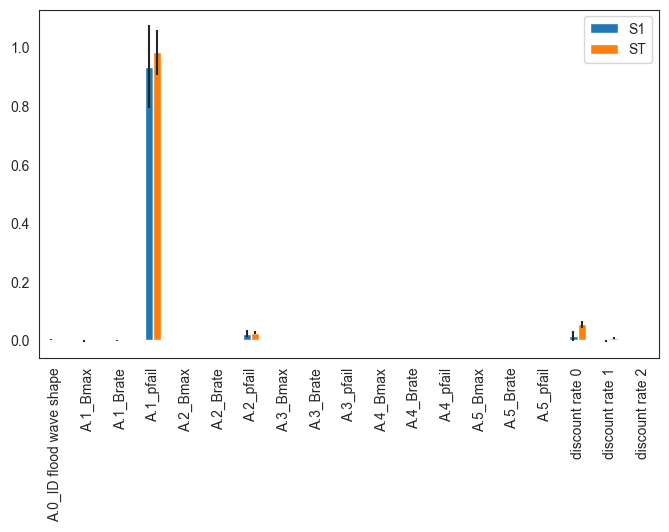

In [16]:
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

The results of the Sobol analysis show that outcome Expected Annual Damage is very sensitive to A1_pfail. It shows little sensitivity to A2_pfail and discount rate 0. The small difference between s1 and ST mean that there are little interaction effects as the first order sensitivity index makes up for almost all of the total sensitivity. 

In [17]:
Y = results_sob["Expected Annual Damage"]

s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(20,n_scenarios,50)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']

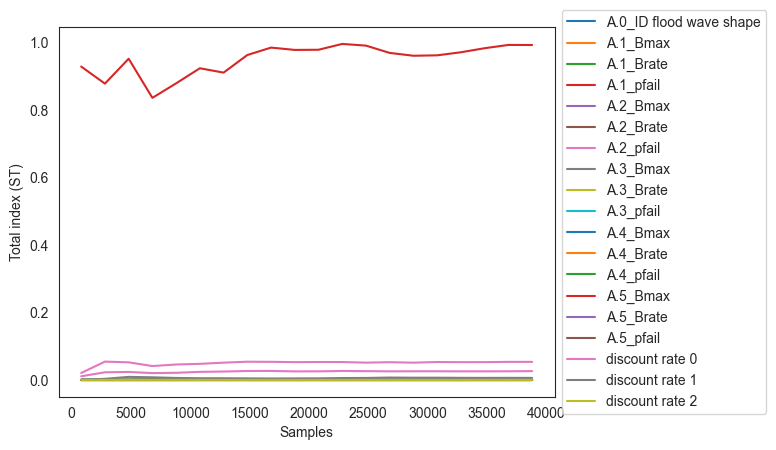

In [18]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

This plot shows the same as the previous one but in a different style.

## Feature scoring

In [19]:
experiments_cleaned = experiments_sob.iloc[:, :19]
experiments_cleaned.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2'],
      dtype='object')

C:\Users\daann\anaconda3.1\envs\mbdm\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


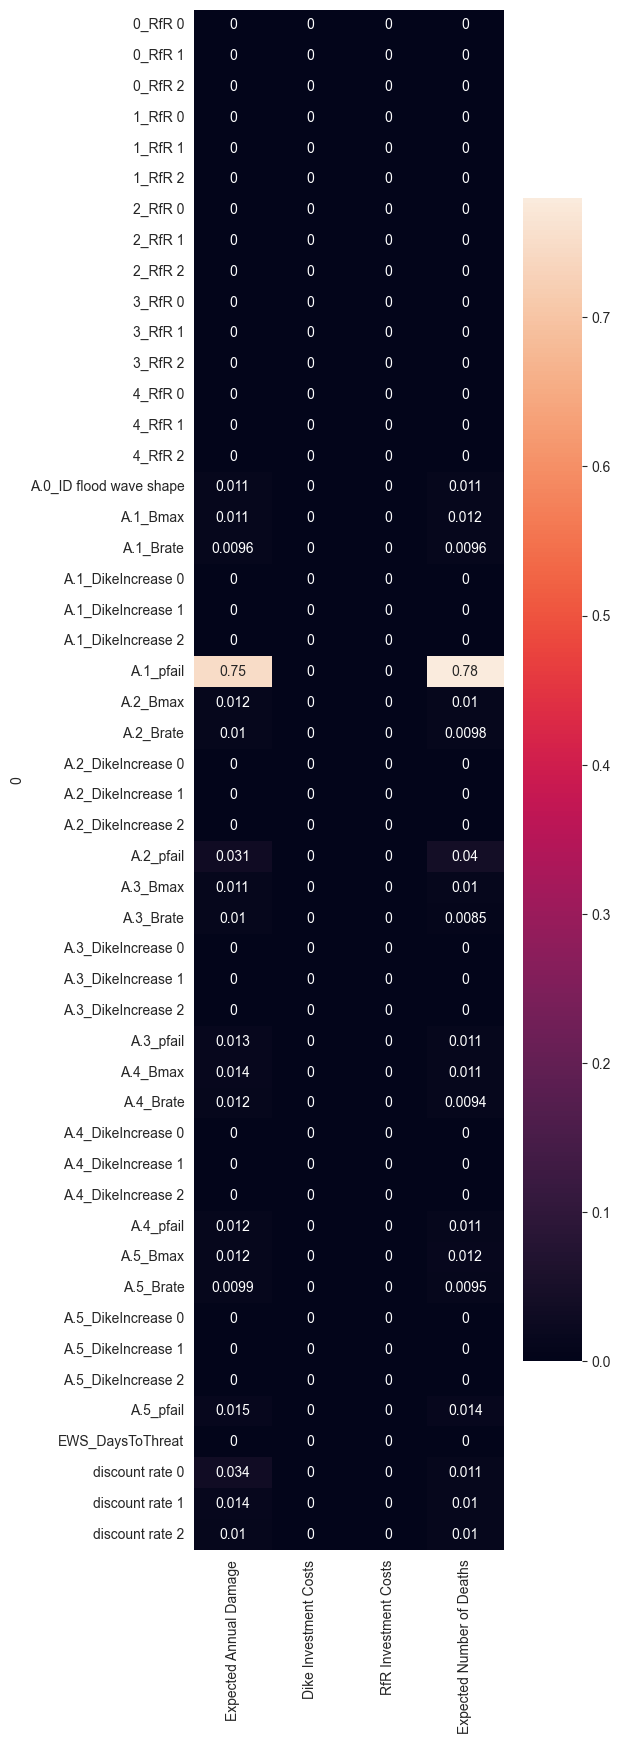

In [23]:
for policy in experiments_sob.policy.unique():
    logical = experiments_sob.policy == policy
    subset_results = {k:v[logical] for k,v in results_sob.items()}
    scores = feature_scoring.get_feature_scores_all(experiments[logical],
                                                   subset_results)
    
    plt.rcParams["figure.figsize"] = (5,20)
    sns.heatmap(scores, annot=True)
    plt.show()

The feature scoring analysis shows a high feature score for expected annual damage and expected annual deaths.  

The fact that both analyses deliver the same results, strengthens our confidence in the findings. 